In [1]:
!pip install -r requirements.txt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import lightgbm as lgb

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/ba/11/cb8b67f3cbdca05b59a032bb57963d4fe8c8d18c3870f30bed005b7f174d/lightgbm-4.3.0-py3-none-manylinux_2_28_x86_64.whl.metadata
  Using cached lightgbm-4.3.0-py3-none-manylinux_2_28_x86_64.whl.metadata (19 kB)
Using cached lightgbm-4.3.0-py3-none-manylinux_2_28_x86_64.whl (3.1 MB)


In [2]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
def label_encode_object_columns(df):
    label_encoder = LabelEncoder()
    df_encoded = df.copy()

    for column in df_encoded.select_dtypes(include=['object']).columns:
        df_encoded[column] = label_encoder.fit_transform(df_encoded[column])

    return df_encoded

## 欠損値の確認

In [4]:
df.isnull().sum()

Term                    0
NoEmp                   0
NewExist                0
CreateJob               0
RetainedJob             0
FranchiseCode           0
RevLineCr            1079
LowDoc                531
DisbursementDate      150
MIS_Status              0
Sector                  0
ApprovalDate            0
ApprovalFY              0
City                    0
State                   0
BankState              11
DisbursementGross       0
GrAppv                  0
SBA_Appv                0
UrbanRural              0
dtype: int64

In [5]:
test.isnull().sum()

Term                    0
NoEmp                   0
NewExist                0
CreateJob               0
RetainedJob             0
FranchiseCode           0
RevLineCr            1041
LowDoc                520
DisbursementDate      160
Sector                  0
ApprovalDate            0
ApprovalFY              0
City                    0
State                   0
BankState              16
DisbursementGross       0
GrAppv                  0
SBA_Appv                0
UrbanRural              0
dtype: int64

## 相関係数の確認

In [6]:
object_columns = ['RevLineCr','LowDoc','DisbursementDate','ApprovalDate','City','State','BankState','DisbursementGross','GrAppv','SBA_Appv']
label_encoder = LabelEncoder()
df_corr = df.copy()
for column in object_columns:
    df_corr[f'label_{column}'] = label_encoder.fit_transform(df_corr[column])
    df_corr.drop(column,axis=1,inplace=True)

<Axes: >

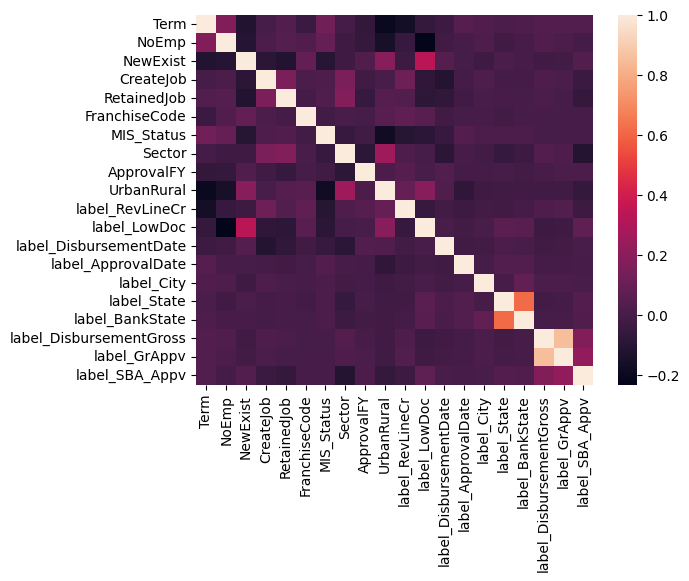

In [7]:
corr = df_corr.corr()
sns.heatmap(corr)

## trainデータとtestデータの分布の確認

In [8]:
X_train = df.copy()
X_test = df.copy()
X_train['adv_target'] = 0
X_test['adv_target'] = 1

In [9]:
train_test_adv = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

train_test_adv.drop('MIS_Status',axis=1,inplace=True)

train_test_adv=label_encode_object_columns(train_test_adv)

train_adv, valid_adv = train_test_split(train_test_adv, test_size=0.2, random_state=42)
X_train_adv = train_adv.drop(['adv_target'], axis=1)
y_train_adv = train_adv['adv_target']
X_valid_adv = valid_adv.drop(['adv_target'], axis=1)
y_valid_adv = valid_adv['adv_target']

model = lgb.LGBMClassifier(
    n_estimators=3000,
    random_state=42)

model.fit(
    X_train_adv,
    y_train_adv,
    eval_set=[(X_train_adv, y_train_adv), (X_valid_adv, y_valid_adv)],
    eval_names=['train', 'valid'],
    eval_metric='auc')

[LightGBM] [Info] Number of positive: 33836, number of negative: 33855
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2432
[LightGBM] [Info] Number of data points in the train set: 67691, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499860 -> initscore=-0.000561
[LightGBM] [Info] Start training from score -0.000561


LGBMClassifier(n_estimators=3000, random_state=42)

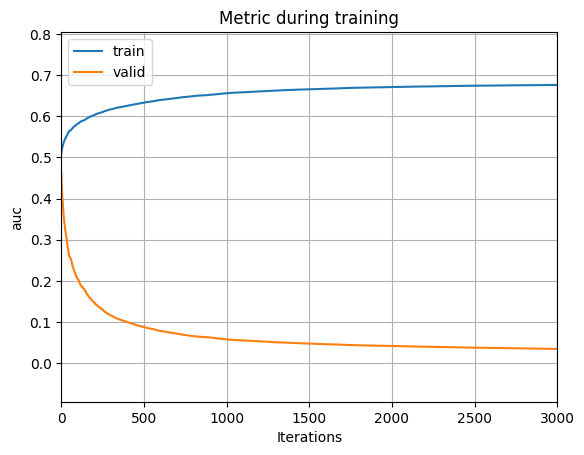

In [10]:
ax = lgb.plot_metric(model.evals_result_, metric='auc')
plt.show()

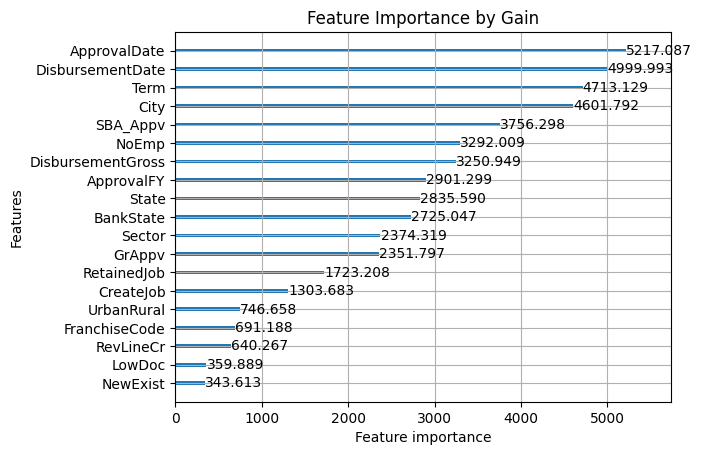

In [11]:
lgb.plot_importance(model, importance_type='gain')
plt.title("Feature Importance by Gain")
plt.show()

## 目的変数割合

In [12]:
category_counts = df['MIS_Status'].value_counts(normalize=True)
category_percentage = category_counts * 100
category_percentage

MIS_Status
1    89.268915
0    10.731085
Name: proportion, dtype: float64